In [4]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../../src/')
from omegaconf import OmegaConf
import numpy as np
import os
import glob
import torch
import pickle
from tqdm import tqdm

In [5]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from diffusion import DiffusionModel
from omegaconf import OmegaConf
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model2 import Autoencoder
import magic
import torch
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

def compute_w2(gen, tru, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    M = ot.dist(gen, tru)
    M = torch.tensor(M, dtype=torch.float32, device=device)
    # M/=M.max()
    assert gen.shape[0] == tru.shape[0]
    n = gen.shape[0]
    a, b = torch.ones((n,)).to(device) / n, torch.ones((n,)).to(device) / n  # uniform distribution on samples
    G0 = ot.emd(a, b, M)
    W = torch.sum(G0 * M)
    return torch.sqrt(W)

def eval_dm(run, ae_run_id, pca_path, folder_path="../../src/wandb/", entity='xingzhis', project='dmae', n_top_genes=10000, seed=423):
    cfg = OmegaConf.create(run.config)
    folder_list = glob.glob(f"{folder_path}*{run.id}*")
    ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
    ckpt_path = ckpt_files[0]
    diffusionmodel = DiffusionModel.load_from_checkpoint(
        checkpoint_path=ckpt_path,
    )
    data_path = '../' + cfg.path + cfg.data
    data_latent = np.load(data_path)
    train_mask = data_latent['train_mask'].astype(bool)
    with torch.no_grad():
        generated_latent = diffusionmodel.generate_samples((~train_mask).sum())
    data_latent_train = data_latent['data'][train_mask]
    mean_, std_ = np.mean(data_latent_train, axis=0), np.std(data_latent_train, axis=0)
    generated_latent = generated_latent * std_ + mean_
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    latent_gen = generated_latent.detach().cpu().numpy()
    latent_test = data_latent['data'][~train_mask]
    latent_train = data_latent['data'][train_mask]

    std = latent_train.std()
    noises = np.arange(1, 10) * 0.1
    w2s = []
    for noise in noises:
        noisy_test = latent_test + np.random.randn(*latent_test.shape) * noise * std
        w2 = compute_w2(noisy_test, latent_test).detach().cpu().numpy()
        w2s.append(w2)

    mean = latent_train.mean(axis=0)
    cov = np.cov(latent_train, rowvar=False)
    rand_samples = np.random.multivariate_normal(mean, cov, latent_test.shape[0])
    
    res = np.array([noises, w2s]).T
    w_rand = compute_w2(rand_samples, latent_test).cpu().numpy()
    w_gen = compute_w2(latent_gen, latent_test).cpu().numpy()

    np.random.seed(seed)
    latent_train_subset_id = np.random.choice(np.arange(len(latent_train)), size=len(latent_test), replace=False)
    latent_train_subset = latent_train[latent_train_subset_id]
    w_train = compute_w2(latent_train_subset, latent_test).cpu().numpy()

    res_dict = dict(
        w_increasing_noise=res,
        w_noise=w_rand,
        w_gen=w_gen,
        w_train=w_train,
    )

    res_dict['latent_train_subset'] = latent_train_subset
    res_dict['latent_test'] = latent_test
    res_dict['latent_gen'] = latent_gen
    res_dict['n_steps'] = cfg.num_steps
    res_dict['data'] = cfg.data
    
    run = api.run(f"{entity}/{project}/{ae_run_id}")
    cfg = OmegaConf.create(run.config)
    folder_list = glob.glob(f"{folder_path}*{run.id}*")
    ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
    ckpt_path = ckpt_files[0]
    data_path2 = os.path.join('../', cfg.data.root, cfg.data.name + cfg.data.filetype)
    data = np.load(data_path2, allow_pickle=True)
    """
    Had to load the checkpoint manually to check the new hyperparameter added in the new code.
    """
    # model = AEDist.load_from_checkpoint(ckpt_path)
    # checkpoint = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
    # if 'dist_std' not in checkpoint['hyper_parameters']:
    #     checkpoint['hyper_parameters']['dist_std'] = 1.0  # Add the missing hyperparameter with default value
    #     checkpoint['state_dict']['dist_std'] = torch.tensor([1.0])
    # model = AEDist(**checkpoint['hyper_parameters'])
    # model.load_state_dict(checkpoint['state_dict'])
    model = Autoencoder.load_from_checkpoint(ckpt_path)
    model.eval()
    with torch.no_grad():
        gen_decoded = model.decoder(generated_latent)
    with torch.no_grad():
        test_decoded = model.decoder(torch.tensor(latent_test, dtype=torch.float32))
    test_ambient = data['data'][~data['is_train'].astype(bool)]
    test_ambient = torch.tensor(test_ambient, dtype=torch.float)
    train_ambient = data['data'][data['is_train'].astype(bool)]
    train_ambient = torch.tensor(train_ambient, dtype=torch.float)
    magic_op = magic.MAGIC()
    x_magic = magic_op.fit_transform(test_ambient.cpu().numpy())
    pc_data = np.load(pca_path)
    pca_loadings = pc_data['pca_loadings']
    data_mean = pc_data['data_mean']
    pca_data = x_magic
    orig_magic = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_magic = np.asarray(orig_magic)
    orig_magic = torch.tensor(orig_magic, dtype=torch.float32)
    pca_data = gen_decoded.cpu().numpy()
    orig_gen = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_gen = np.asarray(orig_gen)
    orig_gen = torch.tensor(orig_gen, dtype=torch.float32)
    pca_data = train_ambient.cpu().numpy()
    orig_train = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_train = np.asarray(orig_train)
    orig_train = torch.tensor(orig_train, dtype=torch.float32)
    pca_data = test_decoded.cpu().numpy()
    orig_dec = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_dec = np.asarray(orig_dec)
    orig_dec = torch.tensor(orig_dec, dtype=torch.float32)
    orig_vars = orig_magic.var(axis=0)
    top_100_idx = torch.argsort(orig_vars).flip(0)[:n_top_genes]
    magic_top100 = orig_magic[:,top_100_idx].cpu().numpy()
    gen_top100 = orig_gen[:,top_100_idx].cpu().numpy()
    dec_top100 = orig_dec[:,top_100_idx].cpu().numpy()
    corrs_magic = np.corrcoef(magic_top100, rowvar=False)
    corrs_gen = np.corrcoef(gen_top100, rowvar=False) 
    corrs_dec = np.corrcoef(dec_top100, rowvar=False)
    mse_gen = ((corrs_magic - corrs_gen)**2).mean()
    mse_dec = ((corrs_magic - corrs_dec)**2).mean()
    res_dict['corrs_magic'] = corrs_magic
    res_dict['corrs_gen'] = corrs_gen
    res_dict['corrs_dec'] = corrs_dec
    res_dict['mse_gen'] = mse_gen
    res_dict['mse_dec'] = mse_dec
    res_dict['orig_magic'] = orig_magic
    res_dict['orig_gen'] = orig_gen
    res_dict['orig_dec'] = orig_dec
    res_dict['orig_train'] = orig_train
    res_dict['top_100_idx'] = top_100_idx.cpu().numpy()
    return res_dict

In [7]:
ids_df = pd.read_csv('../../data/diffusion_model_neurips/differnt_dims.csv')

In [8]:
wandb.login()
api = wandb.Api()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [9]:
ids_df.set_index('run_id', inplace=True)

In [10]:
ids_df

,data.name,dimensions.latent,validation/reconstr_loss,validation/dist_loss
run_id,,,,
ssiq1pox,EB_DiffusionMap,2,0.857137,0.359082
qkffbjya,EB_DiffusionMap,10,0.882789,0.973640
6pv8xm4h,EB_DiffusionMap,20,1.024727,1.576212
1fqcht0r,EB_DiffusionMap,30,1.011602,1.440683
6w4u7r6d,EB_heatgeo,2,0.719850,0.138040
ecpnjm7n,EB_heatgeo,10,0.636760,0.206583
6psrwwtf,EB_heatgeo,20,0.634067,0.263051
pgqfuqt0,EB_heatgeo,30,0.613053,0.274417
iyf72ksn,EB_heatgeo_Denoise.5,2,0.690665,0.062644


In [19]:
ids_df2 = ids_df.copy()
ids_df2['validation/dist_loss'] = ids_df2['validation/dist_loss']/ids_df2['dimensions.latent']

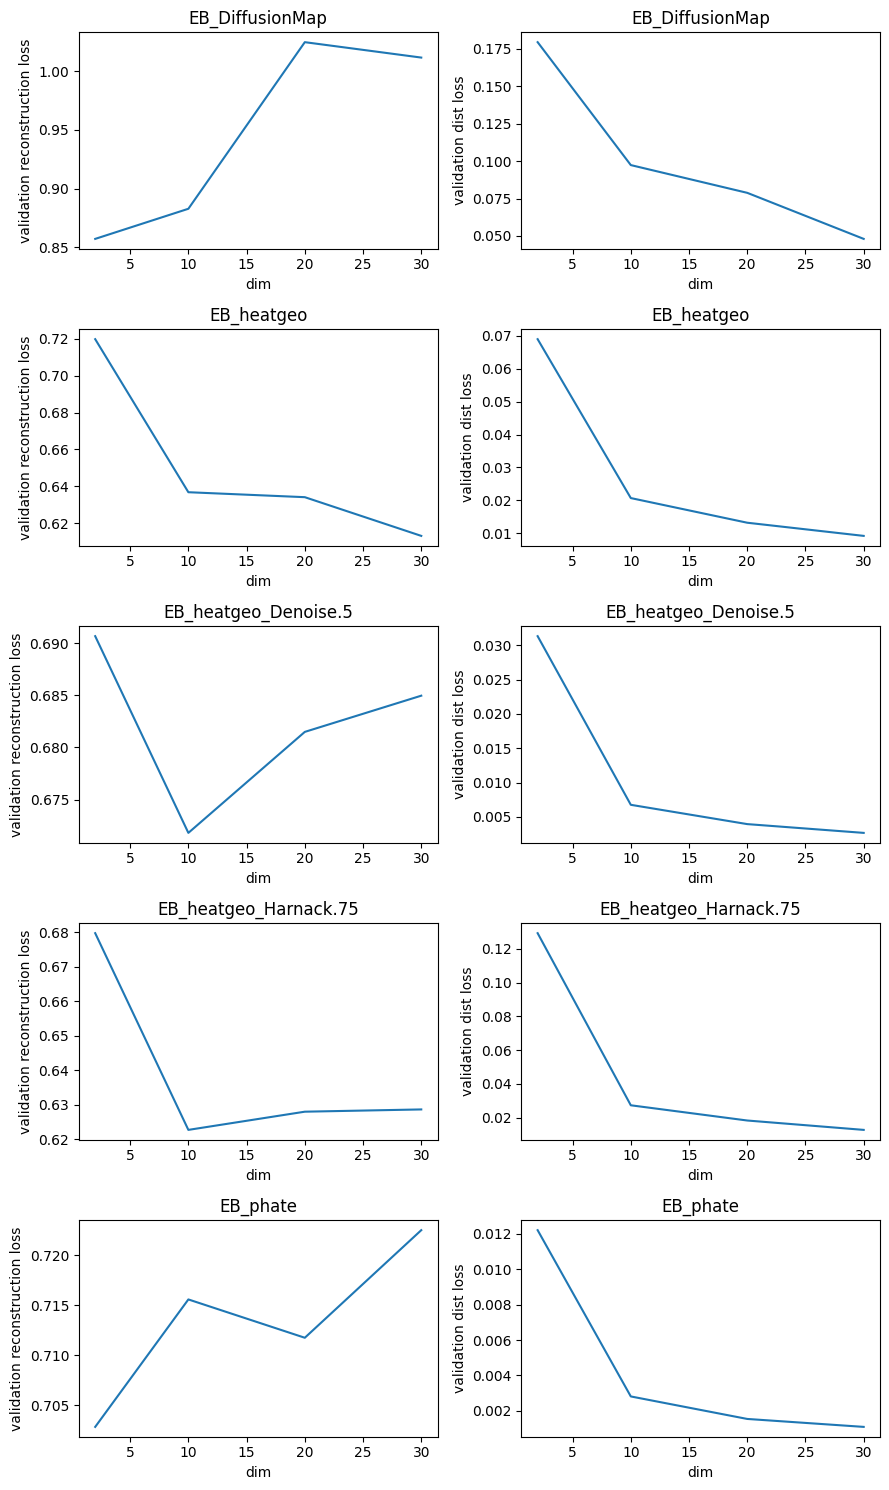

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(ids_df2['data.name'].unique()), 2, figsize=(9, 3*len(ids_df2['data.name'].unique())))
for i, data_name in enumerate(ids_df2['data.name'].unique()):
    ids_df2[ids_df2['data.name'] == data_name][['dimensions.latent','validation/reconstr_loss']].set_index('dimensions.latent').plot(title=data_name, xlabel='dim', ylabel='validation reconstruction loss', legend=False, ax=axes[i,0])
    ids_df2[ids_df2['data.name'] == data_name][['dimensions.latent','validation/dist_loss']].set_index('dimensions.latent').plot(title=data_name, xlabel='dim', ylabel='validation dist loss', legend=False, ax=axes[i,1])
plt.tight_layout()
plt.show()

In [22]:
# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
sweep_id = 'lz6z8vy4'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

In [23]:
# Initialize an empty list to store run data
runs_data = []

# Iterate through each run in the sweep
for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)

In [24]:
data_names = df['data'].unique()

In [36]:
data_names

array(['EB_phate_30_dm.npz', 'EB_phate_20_dm.npz', 'EB_phate_10_dm.npz',
       'EB_phate_2_dm.npz'], dtype=object)

In [29]:
df['num_steps']

0     20000
1     20000
2      5000
3      5000
4      2000
      ...  
91     5000
92    20000
93     5000
94     2000
95     2000
Name: num_steps, Length: 96, dtype: int64

In [35]:
(df['data'] == data_name).any()

False

In [38]:
ids_df3 = ids_df[ids_df['data.name'].apply(lambda x: x.startswith('EB_phate'))]

In [39]:
results = []
for idx in tqdm(ids_df3.index):
    data_name = f"{ids_df3.loc[idx,:]['data.name']}_{ids_df3.loc[idx,:]['dimensions.latent']}_dm.npz"
    run_id = df[(df['data'] == data_name) & (df['num_steps'] == 5000)].sort_values('train_loss_epoch', ascending=True).iloc[0,:]['run_id']
    pca_path = f"../data/{ids_df3.loc[idx,:]['data.name']}_pcs.npz"
    run = api.run(f"{entity}/{project}/{run_id}")
    cfg = OmegaConf.create(run.config)
    res_dict = eval_dm(run, idx, pca_path)
    res_dict['data'] = ids_df3.loc[idx,:]['data.name']
    res_dict['dimensions.latent'] = ids_df3.loc[idx,:]['dimensions.latent']
    results.append(res_dict)

  0%|          | 0/4 [00:00<?, ?it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(
  0%|          | 0/4 [01:09<?, ?it/s]


KeyboardInterrupt: 